In [2]:
import os
import sys
import re
import time
import random
import warnings
import collections
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

sys.path.append('../src')
import cb_utils

sns.set(style="darkgrid")
pd.options.display.max_columns = 500

%load_ext autoreload
%autoreload 2

# DS Patient Matching Exploration

### EDA

In [236]:
df = pd.read_csv('/Users/bp/workspace/cb/data-analytics/notebooks/data/ds_member_matching20221028.csv')
df = df.loc[df.payer_id != 8]
df.head()

,payer_id,patient_id,analytics_member_id,sfere_id,total_impairment_sum,adl_impairment_sum,transfer_bed_to_chair,transfer_chair_to_standing,mobility,dressing,bathing,eating,grooming,toileting,turn_change_position,calling_friends_and_family,articulating_needs,meal_prep,shopping,medication_management,finances,housework,transportation,driving,daily_routine_decisions,comprehension,member_opinion,cleaning,laundry,change_bed,clean_kitchen,clean_home,medical_appointments,work_school_socialize,best_in_class_assessor,assessor,reporting_current_hrs,reporting_rec_hrs,age
0,2,1,3167,33,29,16,2,2,2,2,2,2,2.0,2,NaN,2,1,2,2,NaN,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,Maria Plunkett,30.0,25.0,84
1,2,1,3167,6254,19,14,2,2,2,2,2,0,2.0,2,NaN,1,0,2,0,0.0,0.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,Erin Lenahan,15.0,15.0,84
2,2,2,3678,131,29,19,3,3,3,2,3,0,2.0,3,NaN,0,0,2,2,NaN,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,Maria Plunkett,48.0,40.0,75
3,2,2,3678,9489,26,22,3,3,3,3,3,1,3.0,3,NaN,0,1,1,0,1.0,0.0,1.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,Katy Slaven,48.0,48.0,75
4,2,4,3653,5642,19,14,2,2,2,2,2,0,2.0,2,NaN,0,0,1,1,1.0,0.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,Maria Plunkett,49.0,40.0,52


In [237]:
df.best_in_class_assessor.value_counts()

False    9670
True     1339
Name: best_in_class_assessor, dtype: int64

In [238]:
melted = pd.melt(df, id_vars=['best_in_class_assessor'], value_vars=['reporting_current_hrs', 'reporting_rec_hrs'])

In [239]:
melted.head()

,best_in_class_assessor,variable,value
0,False,reporting_current_hrs,30.0
1,False,reporting_current_hrs,15.0
2,False,reporting_current_hrs,48.0
3,False,reporting_current_hrs,48.0
4,False,reporting_current_hrs,49.0


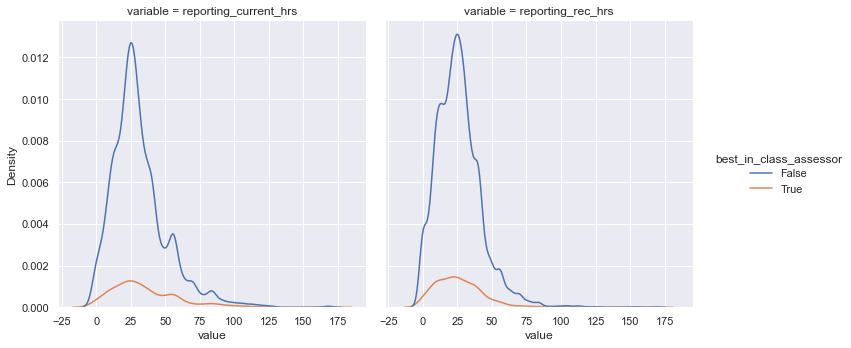

In [240]:
# histogram of total_impairment aka sum(iadl+adl)
sns.displot(data=melted, x="value", hue='best_in_class_assessor', kind='kde', col='variable')

In [241]:
melted = pd.melt(df, id_vars=['best_in_class_assessor', 'total_impairment_sum'], value_vars=['reporting_current_hrs', 'reporting_rec_hrs'])

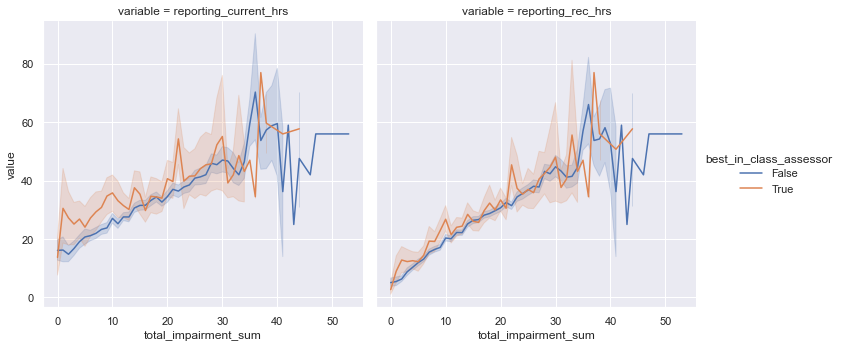

In [242]:
sns.relplot(data=melted, x='total_impairment_sum', y='value', kind='line', hue='best_in_class_assessor', col='variable')

In [245]:
melted = pd.melt(df, id_vars=['best_in_class_assessor', 'adl_impairment_sum'], value_vars=['reporting_current_hrs', 'reporting_rec_hrs'])

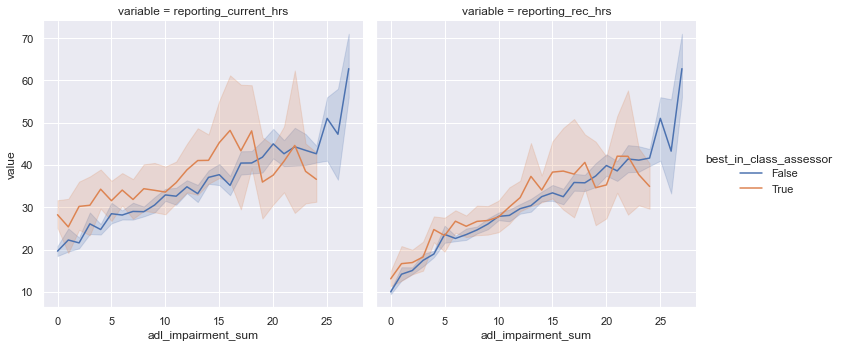

In [246]:
sns.relplot(data=melted, x='adl_impairment_sum', y='value', kind='line', hue='best_in_class_assessor', col='variable')

In [133]:
bic = df.loc[df.best_in_class_assessor]
normie = df.loc[~df.best_in_class_assessor]

In [139]:
(bic.reporting_current_hrs - bic.reporting_rec_hrs).describe()

count    1322.000000
mean        8.464637
std        14.852680
min       -35.000000
25%         0.000000
50%         2.000000
75%        10.000000
max       111.000000
dtype: float64

In [140]:
(normie.reporting_current_hrs - normie.reporting_rec_hrs).describe()

count    9355.000000
mean        5.380143
std        11.930031
min       -24.500000
25%         0.000000
50%         0.000000
75%         5.000000
max       117.000000
dtype: float64

In [145]:
df.reporting_rec_hrs.value_counts()

40.00    488
0.00     468
20.00    454
30.00    424
10.00    390
        ... 
66.50      1
69.25      1
65.30      1
35.35      1
3.75       1
Name: reporting_rec_hrs, Length: 335, dtype: int64

### Signal

In [68]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.neighbors import NearestNeighbors, KNeighborsRegressor

In [227]:
features = [
    'payer_id',
    'age',
    'reporting_current_hrs',
    # 'best_in_class_assessor',
    # adls
    'transfer_bed_to_chair',
    'transfer_chair_to_standing',
    'mobility',
    'dressing',
    'bathing',
    'eating',
    'grooming',
    'toileting',
    'turn_change_position',
    # idls
    'calling_friends_and_family',
    'articulating_needs',
    'meal_prep',
    'shopping',
    'medication_management',
    'finances',
    'housework',
    'transportation',
    'driving',
    'daily_routine_decisions',
    'comprehension',
    'member_opinion',
    'cleaning',
    'laundry',
    'change_bed',
    'clean_kitchen',
    'clean_home',
    'medical_appointments',
    'work_school_socialize'
]
target = 'reporting_rec_hrs'

In [228]:
len(features)

31

In [229]:
# drop na targets from training set
training_df = df.loc[~df[target].isna()]
# training_df = training_df.loc[training_df.best_in_class_assessor]
training_df = training_df.loc[training_df[target] > 0]
# training_df = training_df.loc[training_df[target] <= 40]
X = training_df[features]
y = training_df[target]

In [230]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(f'Train samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}')

Train samples: 8432, Test samples: 2109


In [231]:
est = HistGradientBoostingRegressor().fit(X_train, y_train)
# est = HistGradientBoostingRegressor(categorical_features=[0]).fit(X_train, y_train)
preds = est.predict(X_test)


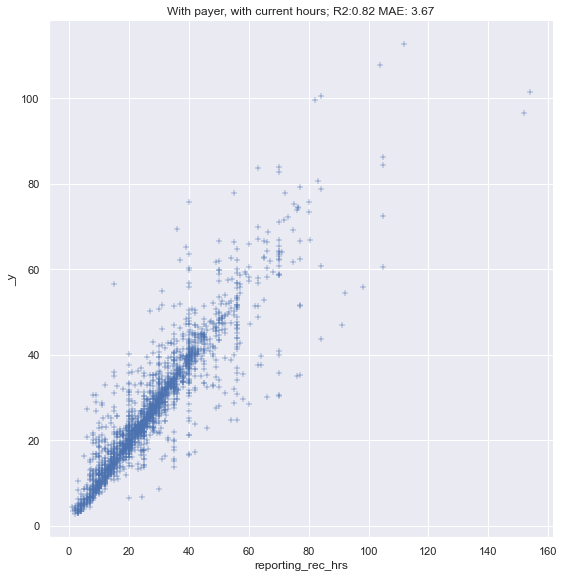

In [232]:
# preds vs rec
ax = sns.relplot(x=y_test, y=preds, marker='+', height=8)
ax.set(title=f'With payer, with current hours; R2:{est.score(X_test, y_test):.02f} MAE: {np.mean(np.abs(y_test - preds)):.02f}')

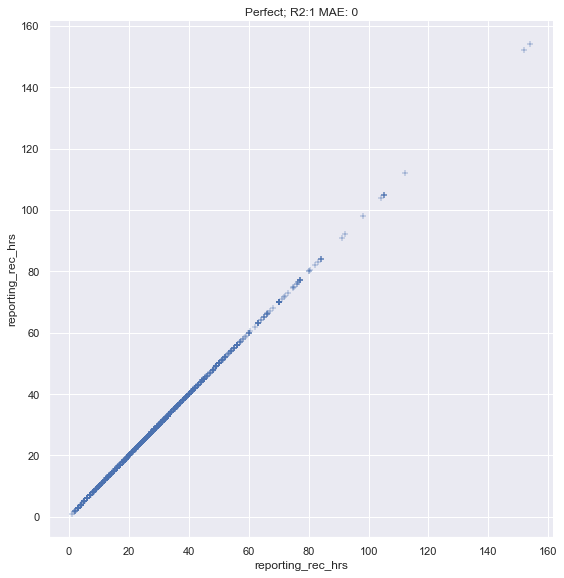

In [234]:
# preds vs rec
ax = sns.relplot(x=y_test, y=y_test, marker='+', height=8)
ax.set(title=f'Perfect; R2:1 MAE: 0')

In [235]:
ax.savefig('/Users/bp/Downloads/perfect.png')

### See how BA model works with non BA 

In [181]:
# retrain on all best in class
est = HistGradientBoostingRegressor().fit(X, y)
# est = HistGradientBoostingRegressor(categorical_features=[0]).fit(X, y)

In [182]:
normies = df.loc[~df[target].isna()]
normies = normies.loc[~normies.best_in_class_assessor]
# training_df = training_df.loc[training_df[target] > 0]
# training_df = training_df.loc[training_df[target] <= 40]
normies_X = normies[features]
normies_y = normies[target]

In [183]:
normie_preds = est.predict(normies_X)
print('R2: ', est.score(normies_X, normies_y))
print(f'Mean absolute error: {np.mean(np.abs(normies_y - normie_preds))}')
print(f'Mean actual - prediction {np.mean(normies_y - normie_preds)}')
print(f'Median actual - prediction: {np.median(normies_y - normie_preds)}')

R2:  0.20911601218946463
Mean absolute error: 10.58025428385515
Mean actual - prediction -2.329227145896636
Median actual - prediction: -3.5395444338662614


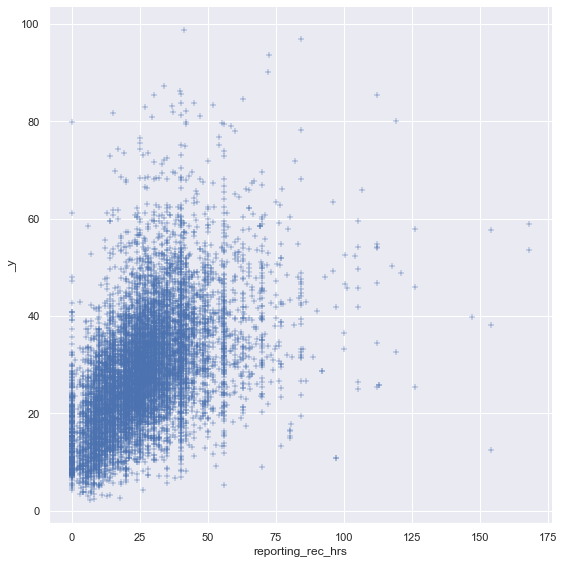

In [184]:
sns.relplot(x=normies_y, y=normie_preds, marker='+', height=8)

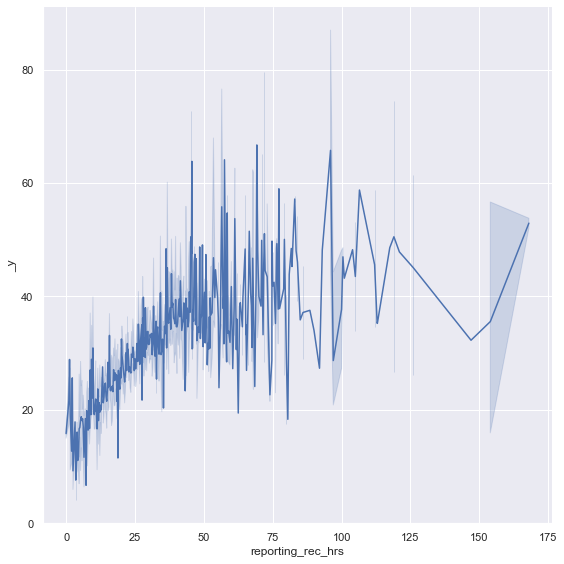

In [178]:
sns.relplot(x=normies_y, y=normie_preds, height=8, kind='line')

### Add bounds with quantile regression
https://en.wikipedia.org/wiki/Quantile_regression

In [148]:
# Set lower and upper quantile
LOWER_ALPHA = 0.1
UPPER_ALPHA = 0.9

lower_model = HistGradientBoostingRegressor(categorical_features=[0], loss="quantile", quantile=LOWER_ALPHA).fit(X_train, y_train)
mid_model = HistGradientBoostingRegressor(categorical_features=[0], loss="quantile", quantile=.5).fit(X_train, y_train)
upper_model = HistGradientBoostingRegressor(categorical_features=[0], loss="quantile", quantile=UPPER_ALPHA).fit(X_train, y_train)

In [150]:
l_preds = lower_model.predict(X_test)
m_preds = mid_model.predict(X_test)
h_preds = upper_model.predict(X_test)

In [151]:
vals = []
for i, p in enumerate(l_preds):
    vals.append([p, 'low', y_test.values[i]])
    
for i, m in enumerate(m_preds):
    vals.append([m, 'med', y_test.values[i]])
    
for i, h in enumerate(h_preds):
    vals.append([h, 'high', y_test.values[i]])
    
# for i, h in enumerate(preds):
#     vals.append([h, 'default', y_test.values[i]])
    
bounds_df = pd.DataFrame(vals, columns=[ 'pred', 'type','value'])
bounds_df.head()
# bounds_df.assign( 

,pred,type,value
0,38.443229,low,52.0
1,28.235041,low,30.0
2,4.337996,low,20.0
3,25.421795,low,28.5
4,42.597692,low,39.0


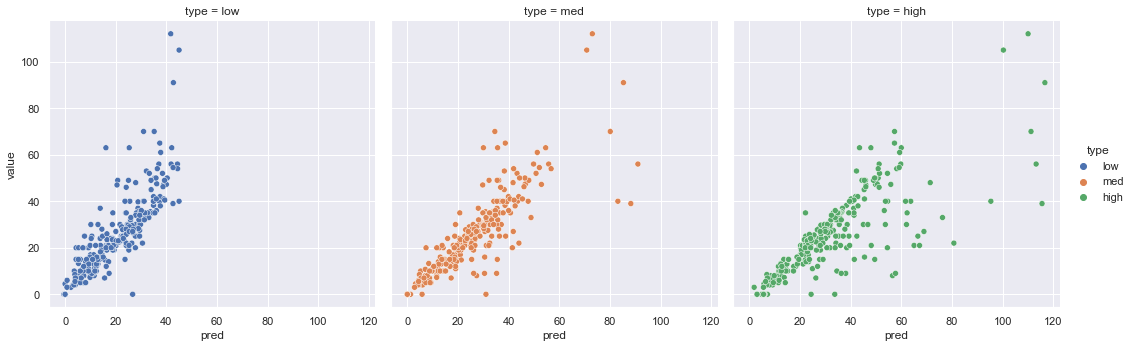

In [152]:
sns.relplot(data=bounds_df, x='pred', y='value', col='type', hue='type') 

### Nearest neighbors

In [ ]:
# need to fill na for knn
X = X.fillna(-1)

In [ ]:
nbrs = NearestNeighbors(n_neighbors=20, p=2, metric='minkowski', n_jobs=-1).fit(X)

In [ ]:
distances, indices = nbrs.kneighbors(X)

In [ ]:
grp_stats = []
sample = 0
for sample in tqdm(range(training_df.shape[0] - 1)):
    neighbor_idxs = indices[sample]
    neighbors_df = training_df.iloc[neighbor_idxs]
    descr = neighbors_df.reporting_rec_hrs.describe()
    grp_stats.append(descr)

In [ ]:
stats = pd.DataFrame(grp_stats)

In [ ]:
stats.describe()

In [ ]:
# try classic KNN regr
neigh = KNeighborsRegressor(n_neighbors=20)

In [ ]:
neigh.fit(X, y)

In [ ]:
neigh.score(X, y)